# Final Project: Toxic Chat Classification Using NLP

## Introduction
In this project, we will be using Natural Language Processing (NLP) to classify toxic comments in a chat. The dataset we will be using is the 
1. ) [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) dataset from Kaggle. The dataset consists of comments from Wikipedia’s talk page edits. The comments are labeled as toxic, severe toxic, obscene, threat, insult, and identity hate. The goal of this project is to build a model that can classify the comments into these categories.
2. ) [Sensai] is a toxic chat dataset consists of live chats from Virtual YouTubers' live streams
   curl -L -o ~/Downloads/archive.zip\ https://www.kaggle.com/api/v1/datasets/download/uetchy/sensai
3. ) [The Toxicity Dataset] This repo contains 500 toxic and 500 non-toxic comments from a variety of popular social media platforms. https://github.com/surge-ai/toxicity

## Members
1. ) HTUN HTET MYAT (BLAKE)
2. ) CHE TAIFU
3. ) MA YONGQIANG
4. ) TANG JIRUI
5. ) ZHANG DAPENG



USE SMOTE for Data Splitting

In [1]:
# Import Statements 
import os
import re
import requests
import nltk
import string
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, Dataset
# import sentencepiece
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer
# from symspellpy import SymSpell, Verbosity
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet
import tensorflow as tf

[nltk_data] Downloading package wordnet to /Users/blake/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/blake/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/blake/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
import tensorflow as tf
# List physical devices
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

# List GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)
else:
    print("No GPU detected.")


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
No GPU detected.
Num GPUs Available:  0


In [2]:
# Default Functions to clean the NLP Dataset, remove stopwords, lemmatize, and stem the words
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
    
def tagged_lemma(string):
    
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(string))

    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []

    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence


def clean_string(text, stem="None"):

    # Final String to return
    final_string = ""

    # Make the text to be lower case
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', ' ', text)

    # Remove punctuations
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [3]:
# Start with Cleaning the Data of Kaggle Toxic Comment Dataset

df_kaggle = pd.read_csv('./data/kaggle-toxic-comment-challange/kaggle_train.csv')
df_sensai = pd.concat([pd.read_parquet(x) for x in glob.glob('./data/sensai/*.parquet')], ignore_index=True)
df_surge = pd.read_csv('./data/surge-ai-toxicity-repo/toxicity_en.csv')

## Pretty print alll the dataframes columns
print(df_kaggle.columns)
print(df_sensai.columns)
print(df_surge.columns)


Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
Index(['body', 'label'], dtype='object')
Index(['text', 'is_toxic'], dtype='object')


In [4]:
#Combine the toxics labels to simply toxic to combine with other datasets
df_kaggle['toxic'] = df_kaggle[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
#Drop the other columns
df_kaggle = df_kaggle.drop(columns=['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

In [5]:
def remove_duplicates(df, text_column):
    df_cleaned = df.drop_duplicates(subset=[text_column], keep='first').reset_index(drop=True)
    return df_cleaned


df_kaggle_cleaned = remove_duplicates(df_kaggle, 'comment_text')
df_sensai_cleaned = remove_duplicates(df_sensai, 'body')
df_surge_cleaned = remove_duplicates(df_surge, 'text')


In [6]:
df_kaggle_cleaned = df_kaggle_cleaned.rename(columns={'comment_text':'comments','toxic':'label'})
df_sensai_cleaned = df_sensai_cleaned.rename(columns={'body':'comments','label':'label'})
df_surge_cleaned = df_surge_cleaned.rename(columns={'text':'comments','is_toxic':'label'})
print(df_kaggle_cleaned.columns)
print(df_sensai_cleaned.columns)
print(df_surge_cleaned.columns)

Index(['id', 'comments', 'label'], dtype='object')
Index(['comments', 'label'], dtype='object')
Index(['comments', 'label'], dtype='object')


In [7]:
# merge
df_combined = pd.concat([df_kaggle_cleaned[['comments','label']], 
                         df_sensai_cleaned[['comments','label']], 
                         df_surge_cleaned[['comments','label']]], 
                         ignore_index=True)
df_combined = df_combined.dropna()
df_combined = remove_duplicates(df_combined, 'comments')
df_combined['text_cleaned'] = df_combined['comments'].apply(lambda x: clean_string(x, stem="Lem"))

df_combined.to_csv('./data/combined_toxicity_data_cleaned.csv', index=False)

In [16]:
#Skipp all to read the cleaned data
df_combined = pd.read_csv('./data/combined_toxicity_data_cleaned.csv')

In [17]:
# Get possible lables values for the dataset
print(df_combined['label'].unique())

['0' '1' 'hidden' 'deleted' 'nonflagged' 'Toxic' 'Not Toxic']


In [18]:
print(df_combined[df_combined['label'] == 0].head(10))
print(df_combined[df_combined['label'] == 1].head(10))
print(df_combined[df_combined['label'] == "deleted"].head(10))
print(df_combined[df_combined['label'] == "nonflagged"].head(10))
print(df_combined[df_combined['label'] == "Toxic"].head(10))
print(df_combined[df_combined['label'] == "Not Toxic"].head(10))
print(df_combined[df_combined['label'] == "hidden"].head(10))

Empty DataFrame
Columns: [comments, label, text_cleaned]
Index: []
Empty DataFrame
Columns: [comments, label, text_cleaned]
Index: []
                                                 comments    label  \
168985  MY NEW DEBU5 IN COMING FEB 14 2021 IT IS DEBUT...  deleted   
168986                                Bilang ara ara dong  deleted   
168988      WKKWW AKU SEPERTINYA BISA NEBAK UMUR KALIAN 😂  deleted   
168993                                  Udah Boker belum?  deleted   
169005                      UDAH PUNYA PACAR BELUM MOONA?  deleted   
169018                                         halo kanna  deleted   
169019                                      DANGDUT WHEN?  deleted   
169021                                 dangdut dong ollie  deleted   
169022                                           Kannnnaa  deleted   
169031                          LAGU INDONESIA DONG OLLIE  deleted   

                                         text_cleaned  
168985                 new  coming feb 

From here we can see the 0 is not toxic, 1 is toxic, flagged as toxic is toxic, not toxic is not toxic, and can remove the noise deleted and not flagged

In [19]:
df_combined = df_combined[~df_combined['label'].isin(['deleted', 'nonflagged','hidden'])]
df_combined['label'] = df_combined['label'].replace({'Toxic': 1, 'Not Toxic': 0})
# Change rememanats of text and integer datatype to the same String type.
df_combined['label'] = df_combined['label'].replace({'1': 1, '0': 0})
df_combined.dropna(subset=['text_cleaned'],inplace=True)
df_combined.reset_index(drop=True, inplace=True)
print(df_combined['label'].unique())

[0 1]


C:\Users\iWOW\AppData\Local\Temp\ipykernel_30464\2814163378.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined['label'] = df_combined['label'].replace({'1': 1, '0': 0})


In [20]:
print(df_combined['label'].unique())

[0 1]


In [21]:
# Find the count of toxic and non-toxic comments
print(df_combined['label'].value_counts())

label
0    143778
1     16725
Name: count, dtype: int64


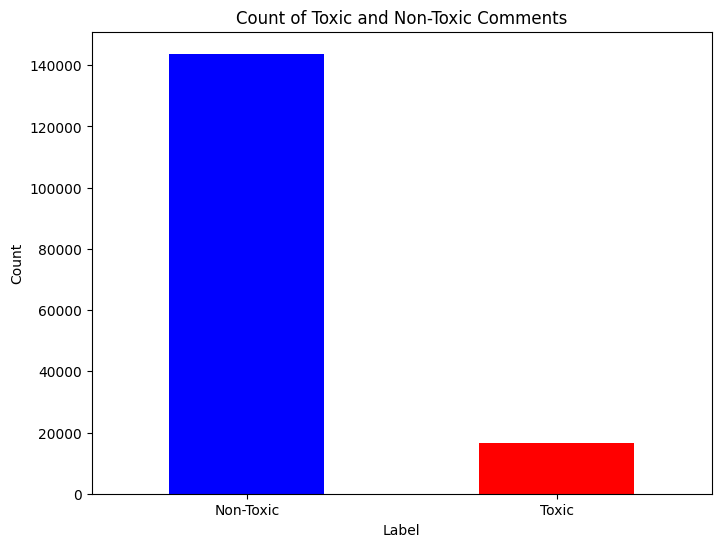

In [22]:
# Count the number of toxic and non-toxic comments
label_counts = df_combined['label'].value_counts()

# Plot the counts
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Count of Toxic and Non-Toxic Comments')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Toxic', 'Toxic'], rotation=0)
plt.show()

In [23]:
# now we see the distribution of the comments is very skewed . Need to balance the dataset
# Split the data into train and test sets

In [24]:
# Split the data into train and test sets with stratification to ensure balance
training_set , test_set = train_test_split(df_combined, test_size=0.2, stratify=df_combined['label'], random_state=42)

In [25]:
# To Create Vectors for Textual Data use the log term frequencey to reduce the weight of common words
# ngram to be 3
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization (
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    pad_to_max_tokens=True
)
encoder.adapt(training_set['text_cleaned'].tolist())

In [59]:
# lstm = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(
#         input_dim=len(encoder.get_vocabulary()),
#         output_dim=64,
#         # Use masking to handle the variable sequence lengths
#         mask_zero=True),
#     tf.keras.layers.LSTM(64), #Replacing the simple RNN with a LSTM
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

lstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64), #Replacing the simple RNN with a LSTM
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [60]:
lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5),
              metrics=['accuracy'])


In [28]:
historyLSTM = lstm.fit(training_set['text_cleaned'],training_set['label'], epochs=10,
                    validation_data=(test_set['text_cleaned'],test_set['label']),
                    batch_size=64,
                    validation_steps=30)
lstm.save('./models/lstm_model.keras')

Epoch 1/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 404s 200ms/step - accuracy: 0.9067 - loss: 0.3364 - val_accuracy: 0.9490 - val_loss: 0.1412
Epoch 2/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 413s 206ms/step - accuracy: 0.9565 - loss: 0.1268 - val_accuracy: 0.9563 - val_loss: 0.1157
Epoch 3/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 463s 231ms/step - accuracy: 0.9602 - loss: 0.1148 - val_accuracy: 0.9516 - val_loss: 0.1302
Epoch 4/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 444s 221ms/step - accuracy: 0.9631 - loss: 0.1029 - val_accuracy: 0.9583 - val_loss: 0.1222
Epoch 5/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 438s 218ms/step - accuracy: 0.9620 - loss: 0.1010 - val_accuracy: 0.9641 - val_loss: 0.0987
Epoch 6/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 443s 221ms/step - accuracy: 0.9633 - loss: 0.0948 - val_accuracy: 0.9536 - val_loss: 0.1185
Epoch 7/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 456s 227ms/step - accuracy: 0.9636 - loss: 0.0926 - val_accuracy: 0.9630 - val_loss: 0.1086
Epoch 8/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 510s 254ms/step - ac

In [61]:
lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [62]:
historyLSTM2 = lstm.fit(training_set['text_cleaned'],training_set['label'], epochs=10,
                    validation_data=(test_set['text_cleaned'],test_set['label']),
                    batch_size=64,
                    validation_steps=30)
lstm.save('./models/lstm_model_sigmoid.keras')

Epoch 1/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 497s 247ms/step - accuracy: 0.8922 - loss: 0.3575 - val_accuracy: 0.9464 - val_loss: 0.1476
Epoch 2/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 500s 249ms/step - accuracy: 0.9565 - loss: 0.1307 - val_accuracy: 0.9604 - val_loss: 0.1128
Epoch 3/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 477s 238ms/step - accuracy: 0.9625 - loss: 0.1099 - val_accuracy: 0.9526 - val_loss: 0.1309
Epoch 4/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 486s 242ms/step - accuracy: 0.9642 - loss: 0.1006 - val_accuracy: 0.9615 - val_loss: 0.1174
Epoch 5/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 485s 242ms/step - accuracy: 0.9638 - loss: 0.0993 - val_accuracy: 0.9698 - val_loss: 0.0908
Epoch 6/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 489s 244ms/step - accuracy: 0.9649 - loss: 0.0958 - val_accuracy: 0.9516 - val_loss: 0.1196
Epoch 7/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 496s 247ms/step - accuracy: 0.9666 - loss: 0.0905 - val_accuracy: 0.9604 - val_loss: 0.1095
Epoch 8/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 489s 243ms/step - ac

In [63]:
pred = lstm.predict(test_set['text_cleaned'])
pred = np.round(pred).astype(int)

1004/1004 ━━━━━━━━━━━━━━━━━━━━ 72s 71ms/step


In [64]:
np.unique(pred)

array([0, 1])

In [65]:
pred_flat = np.round(pred).astype(int).flatten()
print(f"Shape of predictions: {pred_flat.shape}")
print(f"Shape of true labels: {test_set['label'].shape}")

Shape of predictions: (32101,)
Shape of true labels: (32101,)


Confusion Matrix:
[[28279   477]
 [  836  2509]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     28756
           1       0.84      0.75      0.79      3345

    accuracy                           0.96     32101
   macro avg       0.91      0.87      0.88     32101
weighted avg       0.96      0.96      0.96     32101



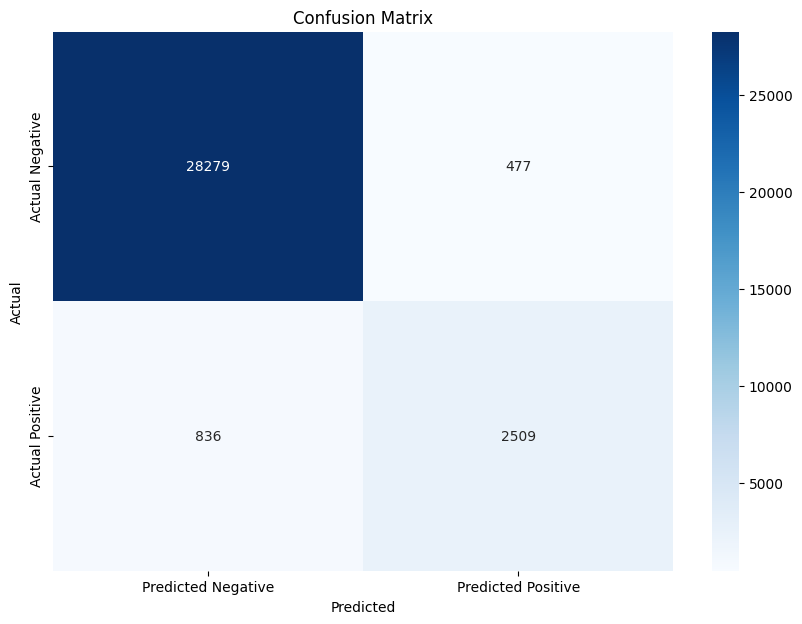

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(test_set['label'], pred)

# Print confusion matrix
# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Print classification report
print("Classification Report:")
print(classification_report(test_set['label'], pred_flat))

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

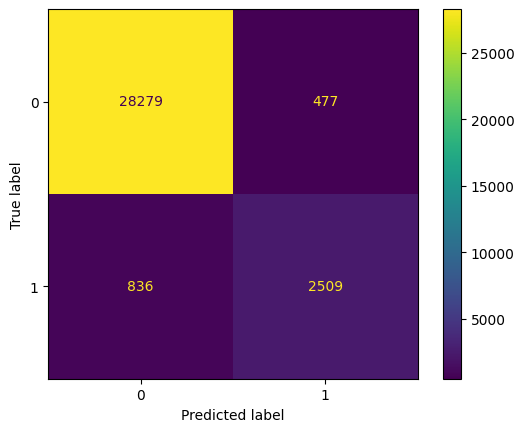

In [67]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [49]:
np.unique(pred_flat)

array([-28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16,
       -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
        -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
        11,  12,  13,  14])

In [29]:
historyLSTM128_20 = lstm.fit(training_set['text_cleaned'],training_set['label'], epochs=20,
                    validation_data=(test_set['text_cleaned'],test_set['label']),
                    batch_size=128,
                    validation_steps=30)
# Save the second model (assuming it's the same model trained with different parameters)
lstm.save('./models/lstm_model_128_20.keras')

Epoch 1/20
 383/1004 ━━━━━━━━━━━━━━━━━━━━ 14:51 1s/step - accuracy: 0.9664 - loss: 0.0789

KeyboardInterrupt: 

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [31]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

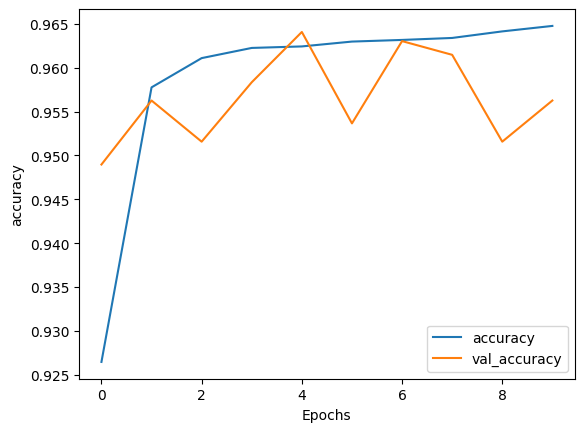

In [32]:
plot_graphs(historyLSTM, "accuracy")

In [87]:
lstm_sigmoid.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,071,749 (4.09 MB)

 Trainable params: 357,249 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 714,500 (2.73 MB)

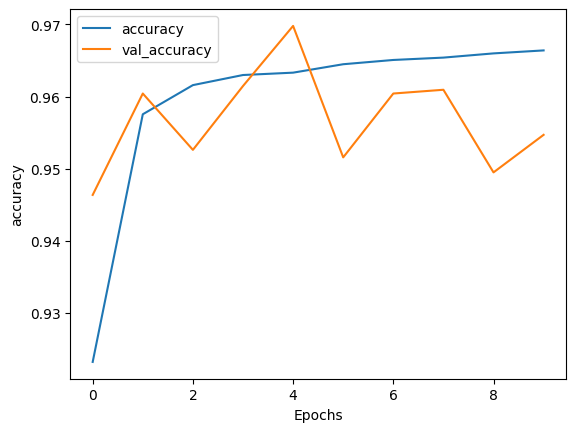

In [68]:
plot_graphs(historyLSTM2, "accuracy")

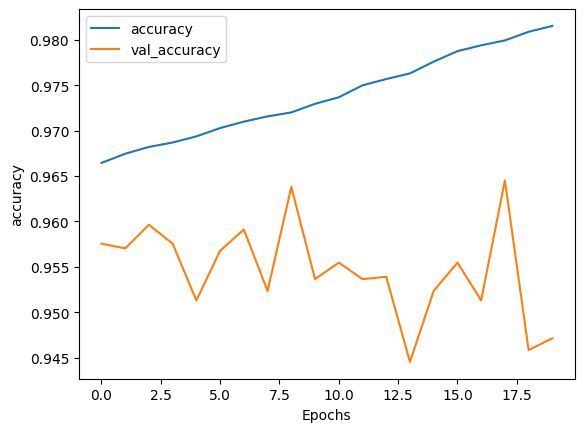

In [ ]:
plot_graphs(historyLSTM128_20, "accuracy")

In [112]:
# Load the model
model_path = './models/lstm_model_sigmoid.keras'
lstm_sigmoid = tf.keras.models.load_model(model_path)

# Define the prediction function
def predict_text(text, model):
    # Clean the text    
    # Convert to TensorFlow tensor with dtype=tf.string
    input_text = tf.constant(text, dtype=tf.string)
    # Make prediction
    prediction = model.predict(input_text)
    
    # Convert prediction to binary
    binary_prediction = np.round(prediction).astype(int).flatten()
    
    return binary_prediction



In [118]:
# Reusults of the model in terms of
model1_path = './models/lstm_model_sigmoid.keras'
lstm_sigmoid = tf.keras.models.load_model(model1_path)
model2_path = './models/lstm_model_128_20.keras'
lstm_128_20 = tf.keras.models.load_model(model2_path)
model3_path = './models/lstm_model.keras'
lstm = tf.keras.models.load_model(model3_path)

test_1 = [
    "cunt.",
    "cunk.",
    "I hope you go kill yourself.",
    "I hope you go un-alive yourself and go to heaven",
    "I'd call you dumb as a rock, but at least a rock can hold a door open...",
    "You’re impossible to underestimate.",
    "I bet your parents change the subject when their friends ask about you.",
    "I envy the people who havent met you",
    "You’re a conversation starter. Not when you are around but once you leave",
    "If you were the light at the end of the tunnel, I’d turn back around",
    "I'd give you a nasty look but you've already got one",
    "I'm genuinely excited to never interact with you again.",
    "If I throw a stick, will you leave?",
    "Everyone who ever loved you was wrong.",
]
test_1 = [string.lower() for string in test_1]

predicted_label1 = predict_text(test_1, lstm_sigmoid)
data1 = {
    "Text": test_1,
    "Label": ["toxic" if result == 1 else "non-toxic" for result in predicted_label1]
}

predicted_label2 = predict_text(test_1,lstm)
data2 = {
    "Text": test_1,
    "Label": ["toxic" if result == 1 else "non-toxic" for result in predicted_label2]
}

predicted_label3 = predict_text(test_1,lstm_128_20)
data3 = {
    "Text": test_1,
    "Label": ["toxic" if result == 1 else "non-toxic" for result in predicted_label3]
}


c:\Users\iWOW\Desktop\EE6405-finalProject\.conda\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


In [120]:

# Create DataFrame
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

# Print the DataFrame side by side
print(df1 , df2, df3)   

                                                 Text      Label
0                                               cunt.      toxic
1                                               cunk.  non-toxic
2                        i hope you go kill yourself.      toxic
3    i hope you go un-alive yourself and go to heaven  non-toxic
4   i'd call you dumb as a rock, but at least a ro...      toxic
5                 you’re impossible to underestimate.  non-toxic
6   i bet your parents change the subject when the...  non-toxic
7                i envy the people who havent met you  non-toxic
8   you’re a conversation starter. not when you ar...  non-toxic
9   if you were the light at the end of the tunnel...  non-toxic
10  i'd give you a nasty look but you've already g...  non-toxic
11  i'm genuinely excited to never interact with y...  non-toxic
12                if i throw a stick, will you leave?      toxic
13             everyone who ever loved you was wrong.  non-toxic                          